# Cat vs Dog Prediction
### In this note book we will test how an Image Recognition Algorithm works using CNN to predict Dog vs Cat images. Source: https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/ 

dataset: https://www.kaggle.com/c/dogs-vs-cats/data - click download all


## Note: datasets , .npy file, train and test sets has been removed from the file path to save space.
# Do not re-run the script please😅😉😎

In [87]:
# import the necessary libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.image import imread

from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.optimizers import SGD
from shutil import copyfile
from random import seed, random

import sys
import os

# Image Storage

### The images were stored in .jpg format, for the trainset, the label names represents the content of the images, while for the testset, the label names contain random numbers since the algorithm would be predicting the names of the images on the testset

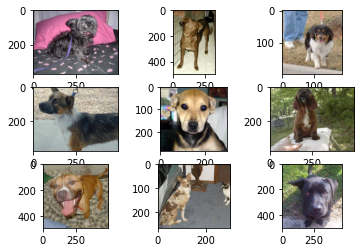

In [12]:
# exploratory data analysis - this case to find out what different photos look like 

# load dataset
folder = "dogs-vs-cats\\train\\"
# plot first few images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# define filename
	filename = folder + 'dog.' + str(i) + '.jpg'
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show()

# Pre-Process Photo Sizes
### Resizing of images help ensure that less amount of computational power is required to porcess the algorithm. Here, we write a custom code to load the images into memory and resize them as part of the loading process, then save them ready for modelling.

### Here Keras image processing API is used to load all 25k photos in the training dataset and reshape them to 200x200 square photos. The label is determined by for each photo by the filenames, and a tuple of photos and labels is then saved. 

<i>Note resizing to 200x200 would take at least 12 GB Ram to process</i>

In [14]:
# define location of dataset
folder = 'dogs-vs-cats\\train\\'
photos, labels = list(), list()
# enumerate files in the directory
for file in os.listdir(folder):
	# determine class
	output = 0.0
	if file.startswith('cat'):
		output = 1.0
	# load image
	photo = load_img(folder + file, target_size=(200, 200))
	# convert to numpy array
	photo = img_to_array(photo)
	# store
	photos.append(photo)
	labels.append(output)
# convert to a numpy arrays
photos = np.asarray(photos)
labels = np.asarray(labels)
print(photos.shape, labels.shape)
# save the reshaped photos
np.save('resized_image\\dogs_vs_cats_photos.npy', photos)
np.save('resized_image\\dogs_vs_cats_labels.npy', labels)

(25000, 200, 200, 3) (25000,)


### After preparation, and storage, the data can be loaded directly; using the method below:

In [15]:
photos = np.load('resized_image\\dogs_vs_cats_photos.npy')
labels = np.load('resized_image\\dogs_vs_cats_labels.npy')
print(photos.shape, labels.shape)

(25000, 200, 200, 3) (25000,)


# Alternative to pre-processing and storage

In [37]:
# first we create sub-directories in the standard folders
dataset_home = r'dogs-vs-cats'
subdirs = ['train\\', 'test\\']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['dogs\\', 'cats\\']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		os.makedirs(newdir, exist_ok=True)

# seed random number generator
seed(1)

# define ratio of pictures to use for validation
val_ratio = 0.25

# copy training dataset images into subdirectories
src_directory = r'dogs-vs-cats'
for file in os.listdir(src_directory):
	src = src_directory + '\\' + file
	dst_dir = 'train\\'
	if random() < val_ratio:
		dst_dir = 'test\\'
	if file.startswith('cat'):
		dst = dataset_home + dst_dir + 'cats\\'  + file
		copyfile(src, dst)
	elif file.startswith('dog'):
		dst = dataset_home + dst_dir + 'dogs\\'  + file
		copyfile(src, dst)

# Develop a Baseline CNN Model

In [88]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	plt.savefig(filename + '_plot.png')
	plt.close()


# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow_from_directory('dogs-vs-catstrain',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('dogs-vs-catstest',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
	# evaluate model
	_, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

In [89]:
run_test_harness()

C:\Users\chiso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
Found 9323 images belonging to 2 classes.
Found 3177 images belonging to 2 classes.
C:\Users\chiso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
C:\Users\chiso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tensorflow\python\keras\engine\training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and